Plot AWS versus WRF(CESM LE). All plots focus on "best" AWS sites.
======

Import custom modules for working with model and AWS data
----

In [1]:
import sys

# Test to see if running in batch or browser
tst = sys.argv[1]
if "-f" not in tst:
    print "Running in batch"
    batch = 1
else:
    print "Running in browser"
    batch = 0
    %matplotlib inline
    %config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
    
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.text import Text
from datetime import datetime
from collections import OrderedDict

%load_ext autoreload
%autoreload 2
from model import Model
from GCNet import GCNet
from plotUtils import PlotUtils

pd.options.mode.chained_assignment = None

Running in browser


Function: subset a variable by years, months, QC
---

In [2]:
def subsetData( X, yrRange = None, monRange = None, qcFunc = None, qcLevel = None, qcIX = None):
    """
        yrRange = (year1, year2), i.e., a range of years
        monRange = (m1, m2, m3...), i.e., a list of explicit month numbers
        qcFunc = function handle for qcStats
        qcLevel = x, i.e., a percent cutoff
        qcIX = existing index for QC slicing
    """

    # first, subset by year range
    if yrRange is not None:
        yrStart = yrRange[0]
        yrEnd = yrRange[1]
        yearSub = range( yrStart, yrEnd+1 )
        Xnew = X.loc[ X['year'].isin(yearSub)]
        X = Xnew

    # second, subset by month range
    if monRange is not None:
        Xnew = X.loc[ X['month'].isin(monRange)]
        X = Xnew

    # third, subset by data quality
    if qcLevel is not None:
        if qcIX is None:  # create a new QC index
            qcPct = qcFunc( X.iloc[:,:-2] )
            qcIX = qcPct > qcLevel

        Xtemp = X.iloc[:,:-2]  # temporarily drop time, year and month columns
        Xbest = Xtemp.iloc[:,qcIX]
        Xbest['month'] = X['month']  # restore month column
        X = Xbest

    # drop sites with no valid data
    Xvalid = X.dropna(axis='columns',how='all')
    
    if 'year' in Xvalid.columns:
        Xvalid.drop('year', axis=1, inplace=True)
    
    # return data subset and the QC index used
    return ( Xvalid, qcIX )

Function: create a title string
---

In [3]:
def makeTitle( modelName, varName, srcFile, yrRange, enss, monStr = None, qcFlag = False ):
    # build up a title string from variable components
    
    titleStr = modelName+'('+enss+')'
    titleStr = titleStr+' Daily '+varName
    titleStr = titleStr+' '+str(yrRange[0])+'-'+str(yrRange[1])
    if monStr is not None:
        titleStr = titleStr+', '+monStr
    if srcFile is not None:
        titleStr = titleStr+', '+srcFile+' vs Best AWS'
    else:
        titleStr = titleStr+', Closest vs Interpolated'
    if srcFile is not None:
        if qcFlag:
            titleStr = titleStr+' ('+qcCutoffStr+')'
    return titleStr

Global settings
---

In [4]:
modelName = "WRF CESM LE"
cutLimit = 0.5 # parameter for ends of violinPlot distributions
bandWidth = 0.1
yTickInterval = 5  # y axis tick interval
qcCutoff = 50
qcCutoffStr = "> "+str(qcCutoff)+"%"

allStr = "All Year"

period = "historical"
# period = "rcp85"

# Test to see if running in batch or browser
if batch == 1:
    print "Running in batch"
    ens = int(sys.argv[1])
else:
    print "Running in browser"
    ens = -1  # ensemble number, 1-based (or -1 for ensemble average)
#     ens = -2  # ensemble number, 1-based (or -1 for ensemble average)

scaleType = "count"
if ens > 0:
    enss = "%02d" % ens
else:
    if ens == -1:
        enss = "avg"
    else:
        enss = "all"
        scaleType = "area"

print "Ensemble = "+enss

Running in browser
Ensemble = avg


Setup plotting
----

In [5]:
plotOptions = { "saveFigure": False }
# plotOptions = { "saveFigure": True }
P = PlotUtils( plotOptions )

Load AWS metadata
----

In [6]:
home = os.path.expanduser("~")
metaFN = "site_info.nc"
gcnetDir = home+"/Documents/GCNet/current"
dataFN = gcnetDir+"/gcnet.allStationData_d_365.nc"
A = GCNet( metaFN, dataFN )
A.loadMeta()

Read AWS time and data, add columns for "year" and "month"
-----

In [7]:
time = A.loadData( "time", True )
Taws = A.loadData( "AirT1", True )
awsCols = Taws.columns.values
# print awsCols

# add column with just the year (for subsetting later)
Taws['year'] = Taws["Time"].apply( lambda Taws : 
                                    datetime(year=Taws.year, month=Taws.month, day=Taws.day).year)
# add column with just the month (for subsetting later)
Taws['month'] = Taws["Time"].apply( lambda Taws : 
                                    datetime(year=Taws.year, month=Taws.month, day=Taws.day).month)

# drop column 1 (Time)
Taws = Taws.iloc[:,1:]

hours since 1900-01-01 00:00:00
noleap
RHS: Resetting value 18.121666
LHS: Resetting value 14.764

/Users/dbr/python_modules/GCNet.py:151: RuntimeWarning: invalid value encountered in greater
  Y = np.array( X )
/Users/dbr/python_modules/GCNet.py:97: RuntimeWarning: invalid value encountered in greater
  Xqc = np.where( X > 20., np.nan, X )
/Users/dbr/python_modules/GCNet.py:153: RuntimeWarning: invalid value encountered in greater
  Yqc = np.where( Yqc > 1.e36, np.nan, Yqc )


Read/create WRF(CESM LE) metadata
----

In [8]:
# historical
if period == "historical":
    Syr = 1996 # beginning of AWS record (ignoring partial 1995 data)
    Eyr = 2005 # end of CESM historical
    compLoc = "upper left"  # legend location for 4-way comparison plot

# rcp85
if period == "rcp85":
    Syr = 2071
    Eyr = 2080
    compLoc = "lower right"  # legend location for 4-way comparison plot

suff = str(Syr)+"-"+str(Eyr)
metaFN = "wrf_geog.nc"

# #  interpolated data
# intModelFN = "wrf_cesmle_tas_interp_"+suff+".nc"
# Mint = Model(metaFN, intModelFN)
# Mint.loadMeta()

# closest point data
clModelFN = "wrf_cesmle_tas_closest_"+suff+"_JJA.nc"
Mcl = Model(metaFN, clModelFN)
Mcl.loadMeta()

# geography
minLon = -70 + 360
maxLon = -15 + 360
minLat = 58
maxLat = 86.5
Mcl.setDomain( (minLat, maxLat, minLon, maxLon) )

# variable
varName = "tas"

2d dataset


Load closest-point WRF(CESM LE) data, AVG
------

In [9]:
srcFile = "Closest"
timeModel = Mcl.loadData( "time", True )
Tmodel1 = Mcl.loadData( varName, True, ens )
Tmodel1.columns = awsCols

# add column with just the year (for subsetting later)
Tmodel1['year'] = Tmodel1["Time"].apply( lambda Tmodel1 : 
                                    datetime(year=Tmodel1.year, month=Tmodel1.month, day=Tmodel1.day).year)
# add column with just the month (for subsetting later)
Tmodel1['month'] = Tmodel1["Time"].apply( lambda Tmodel1 : 
                                    datetime(year=Tmodel1.year, month=Tmodel1.month, day=Tmodel1.day).month)

# drop column 1 (Time)
Tmodel1 = Tmodel1.iloc[:,1:]

Closest, WRF(CESMLE) period, subset to JJA
-----------

y-axis limits: -35, 15


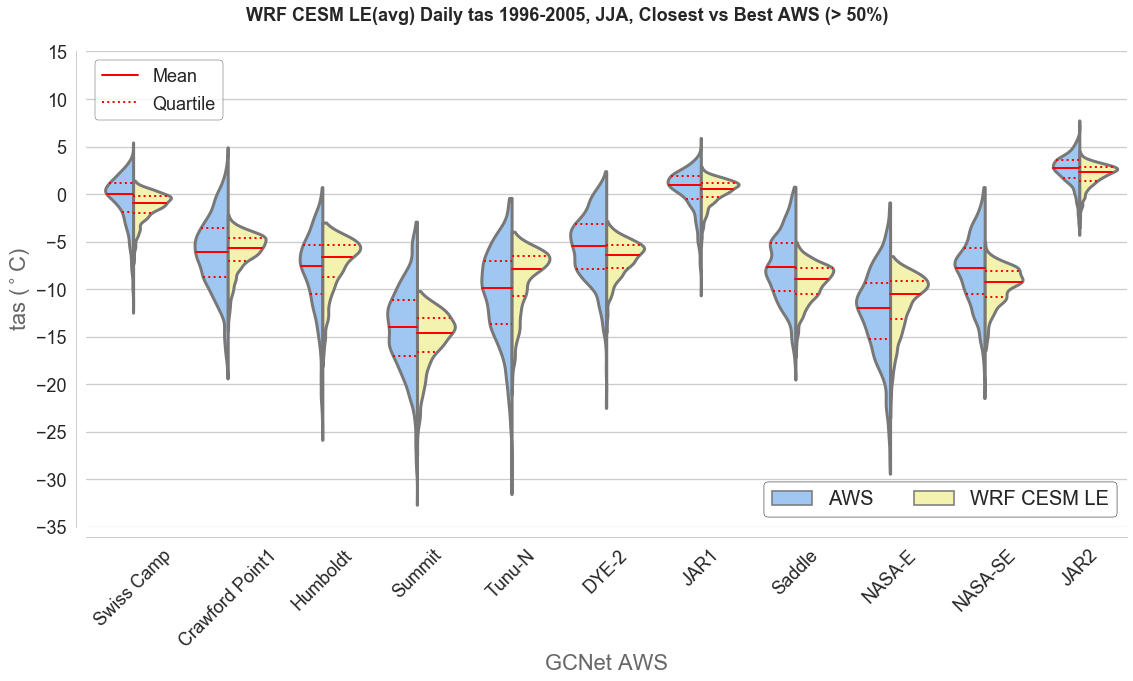

In [10]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "JJA"
monSub = [ 6, 7, 8]
P.setOption( {"bandWidth": 0.2, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, WRF(CESMLE) period, subset to Jun
-----------

y-axis limits: -30, 20


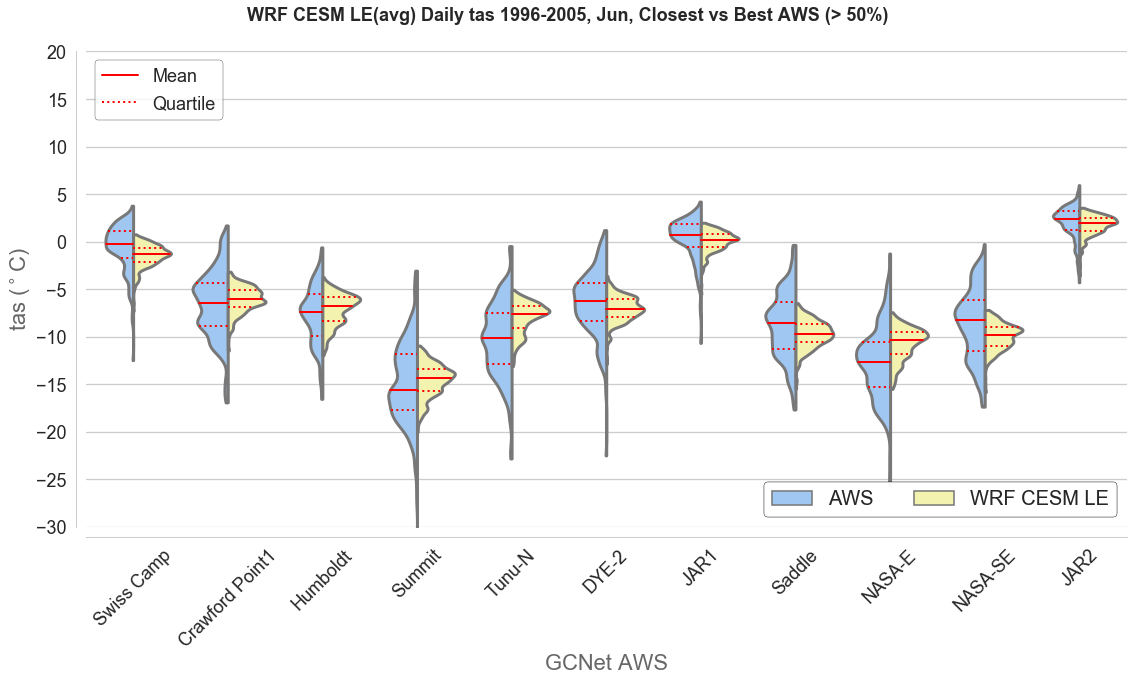

In [11]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jun"
monSub = [6]
P.setOption( {"bandWidth": 0.2, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, WRF(CESMLE) period, subset to Jul
-----------

y-axis limits: -30, 20


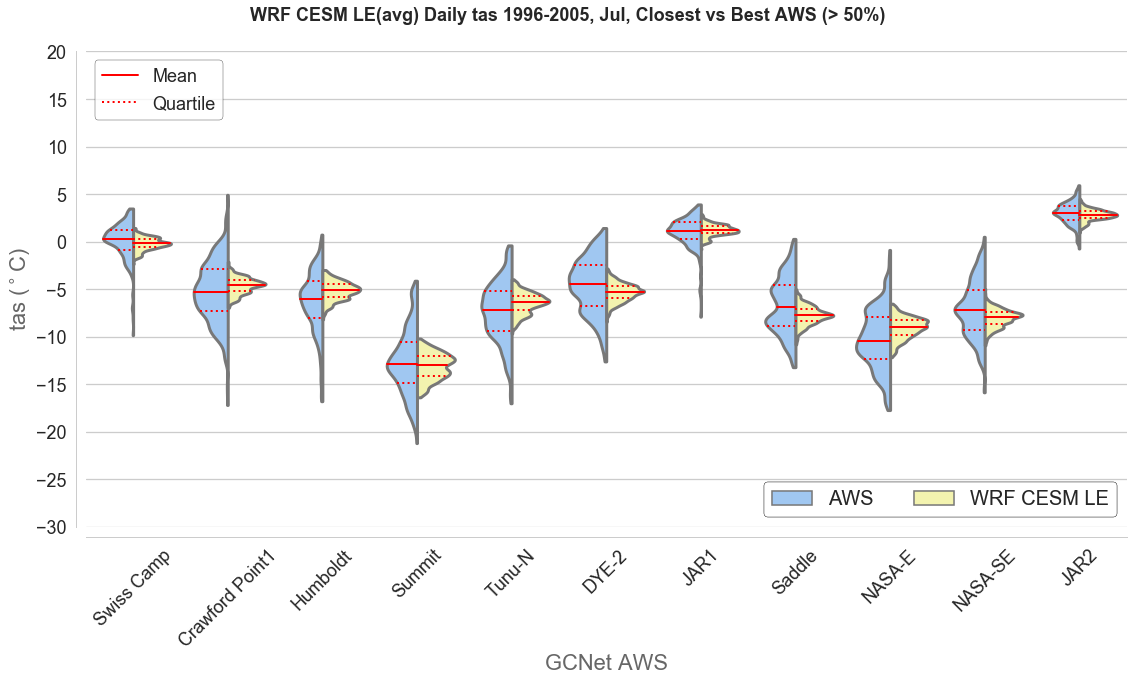

In [12]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jul"
monSub = [7]
P.setOption( {"bandWidth": 0.2, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, WRF(CESMLE) period, subset to Aug
-----------

y-axis limits: -30, 20


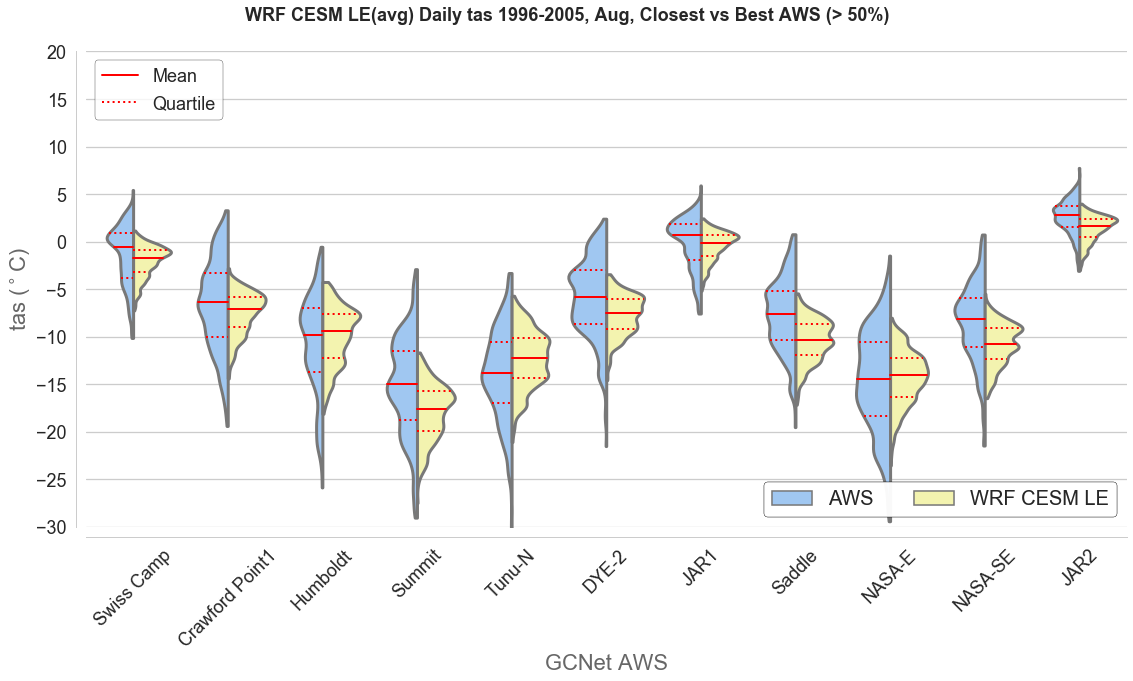

In [13]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Aug"
monSub = [8]
P.setOption( {"bandWidth": 0.2, "type": subStr} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Plots with ALL data
===

Load closest-point WRF(CESM LE) data, ALL ensemble members
------

In [14]:
ens = -2
enss = "all"

srcFile = "Closest"
timeModel = Mcl.loadData( "time", True )
Tmodel3 = Mcl.loadData( varName, True, ens )
Tmodel3.columns = awsCols

# add column with just the year (for subsetting later)
Tmodel3['year'] = Tmodel3["Time"].apply( lambda Tmodel3 : 
                                    datetime(year=Tmodel3.year, month=Tmodel3.month, day=Tmodel3.day).year)
# add column with just the month (for subsetting later)
Tmodel3['month'] = Tmodel3["Time"].apply( lambda Tmodel3 : 
                                    datetime(year=Tmodel3.year, month=Tmodel3.month, day=Tmodel3.day).month)

# drop column 1 (Time)
Tmodel3 = Tmodel3.iloc[:,1:]

Closest, WRF(CESMLE) period, subset to JJA, ALL
-----------

y-axis limits: -35, 15


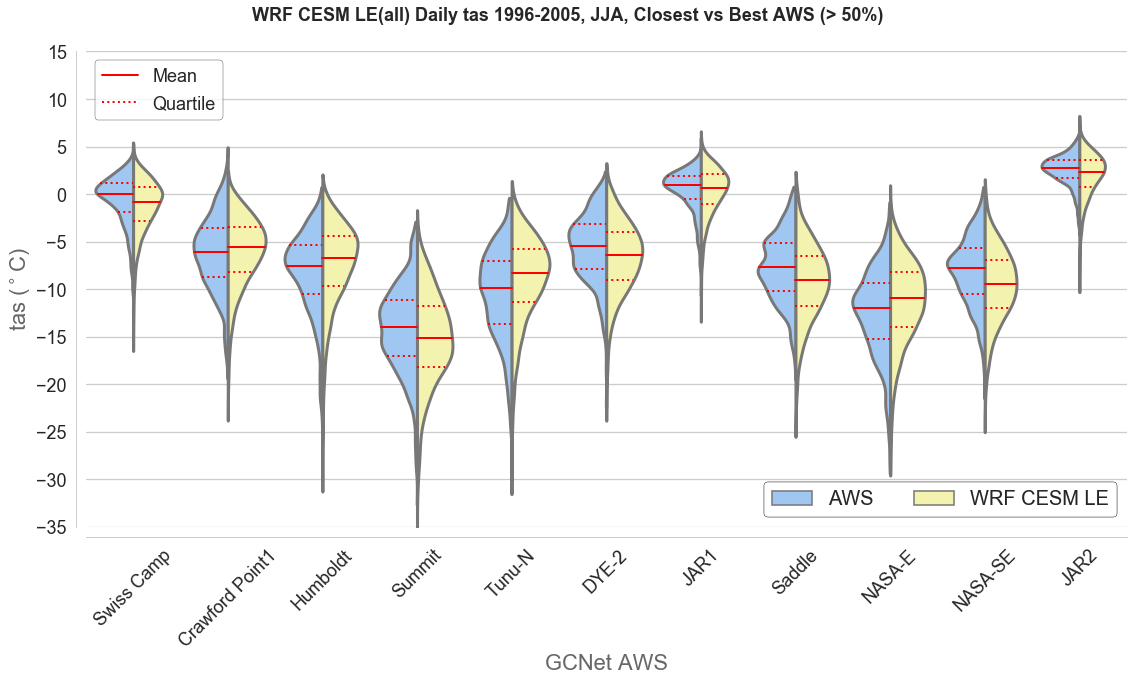

In [15]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "JJA"
monSub = [ 6, 7, 8]
scaleType = "area"
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, WRF(CESMLE) period, subset to Jun, ALL
-----------

y-axis limits: -30, 20


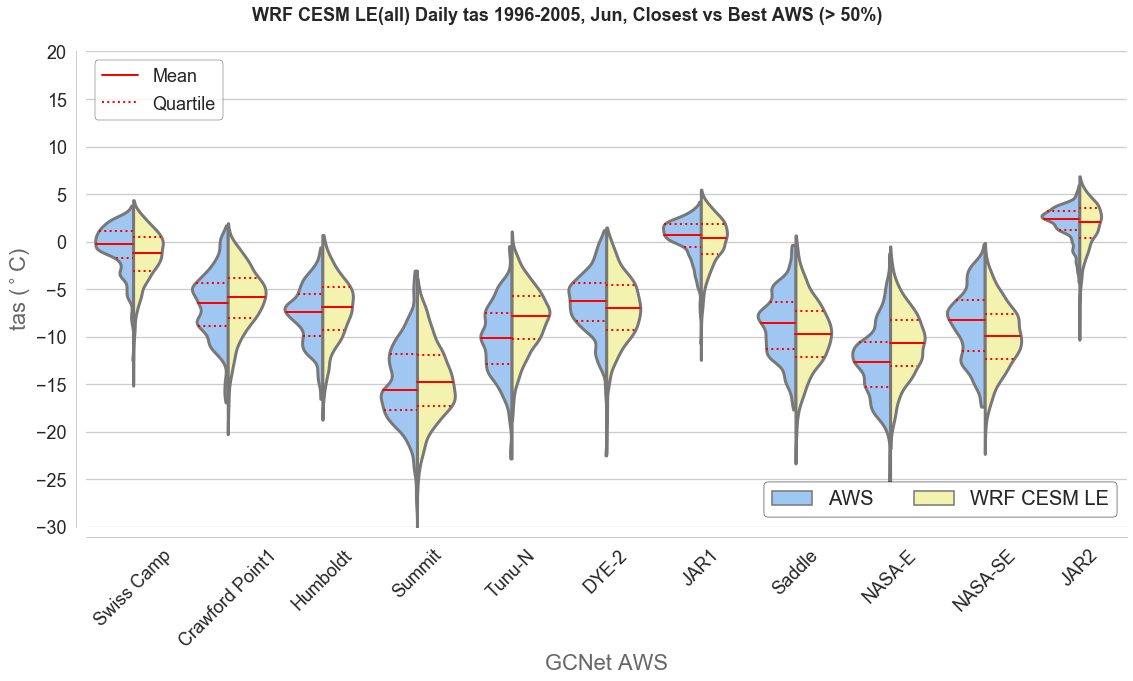

In [16]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jun"
monSub = [6]
scaleType = "area"
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, WRF(CESMLE) period, subset to Jul, ALL
-----------

y-axis limits: -30, 20


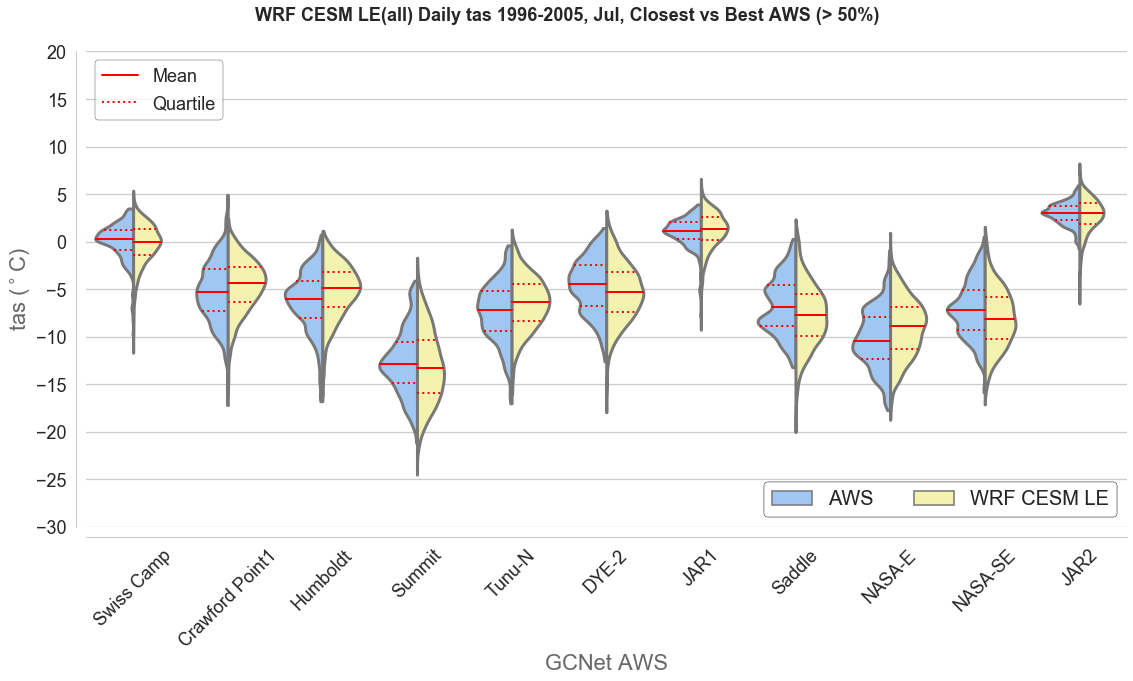

In [17]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jul"
monSub = [7]
scaleType = "area"
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, WRF(CESMLE) period, subset to Aug, ALL
-----------

y-axis limits: -30, 20


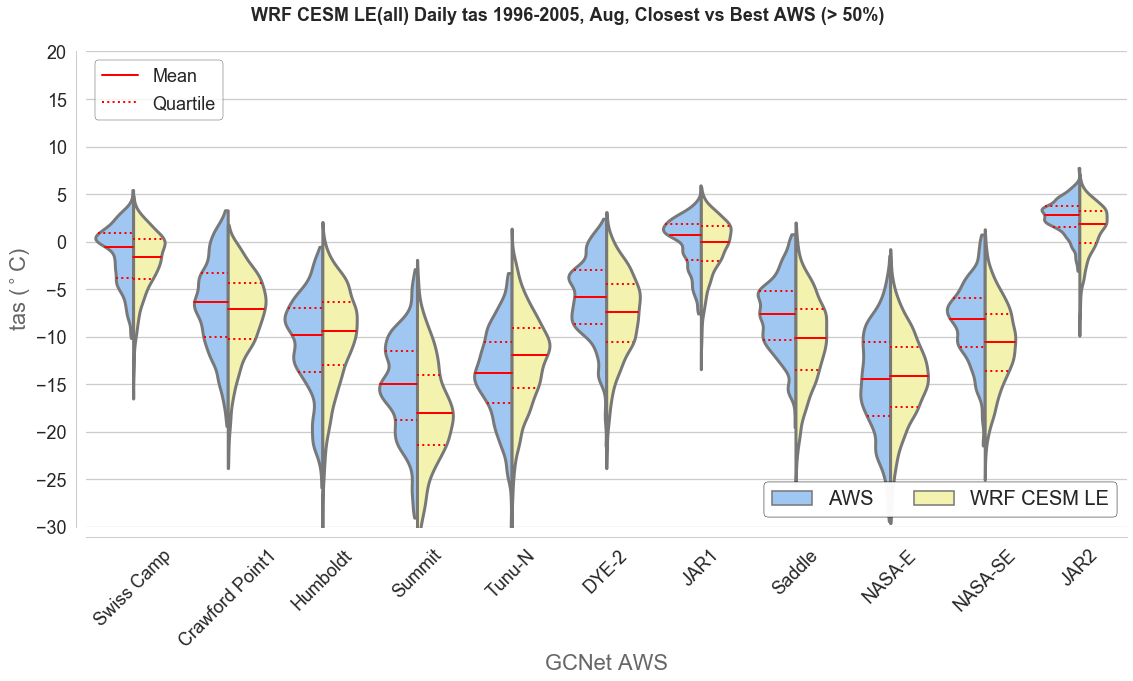

In [18]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Aug"
monSub = [8]
scaleType = "area"
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
TmodelValid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Plots with overlays
===

Closest, CESMLE period, JJA:  compare average to all
-----------

y-axis limits: -35, 15


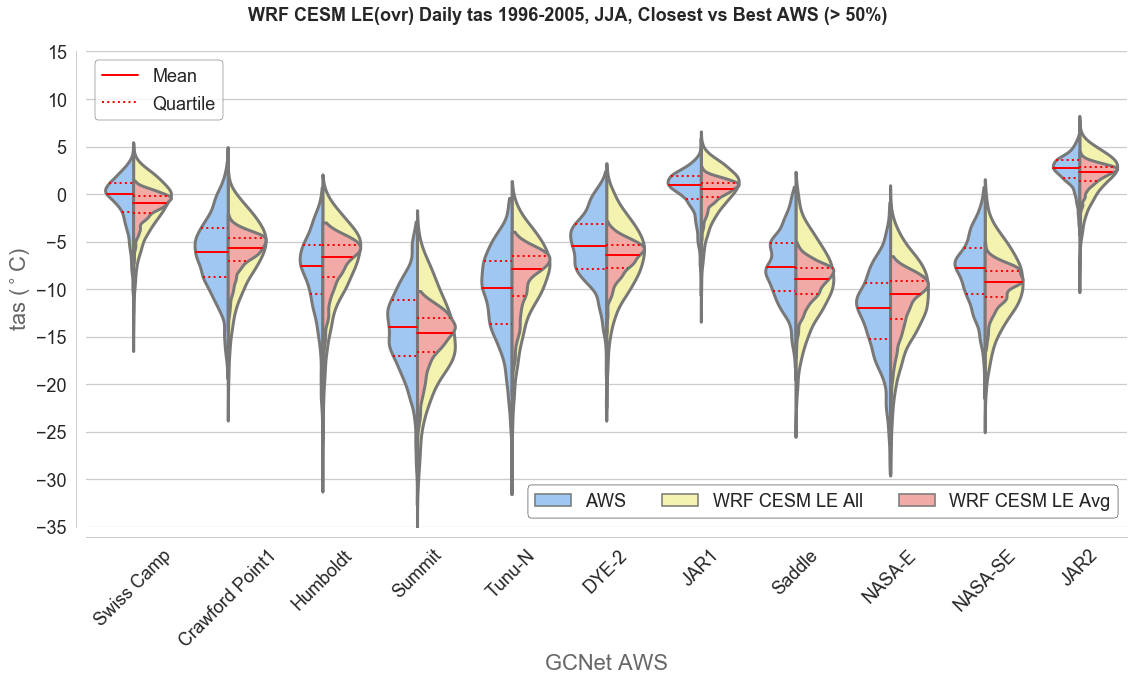

In [19]:
enss = "ovr"

yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "JJA"
monSub = [ 6, 7, 8 ]
##scaleType = "area"  # no good due to doing plots twice
scaleType = "count" # subjectively best choice
# scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": "quartile" } )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( TawsValid, None, Tmodel3Valid, Tmodel1Valid, titleStr, "AWS", modelName, ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, CESMLE period, Jun:  compare average to all
-----------

y-axis limits: -30, 20


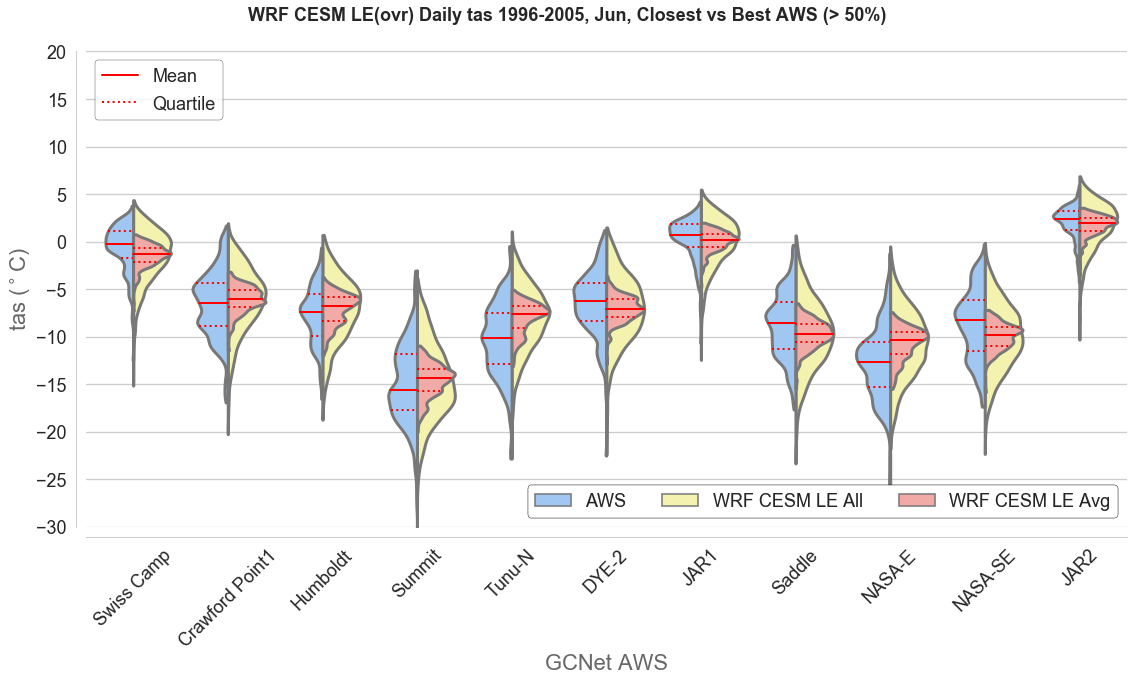

In [20]:
enss = "ovr"

yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jun"
monSub = [6]
##scaleType = "area"  # no good due to doing plots twice
scaleType = "count" # subjectively best choice
# scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": "quartile" } )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( TawsValid, None, Tmodel3Valid, Tmodel1Valid, titleStr, "AWS", modelName, ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, CESMLE period, Jul:  compare average to all
-----------

y-axis limits: -30, 20


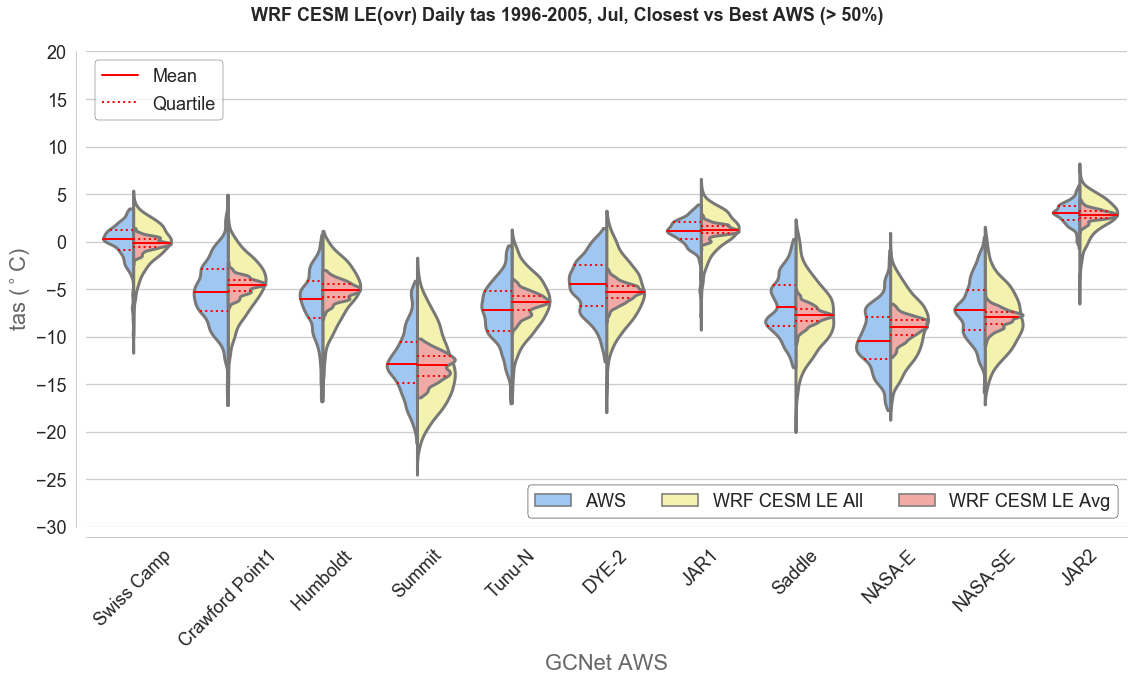

In [21]:
enss = "ovr"

yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jul"
monSub = [7]
##scaleType = "area"  # no good due to doing plots twice
scaleType = "count" # subjectively best choice
# scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": "quartile" } )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( TawsValid, None, Tmodel3Valid, Tmodel1Valid, titleStr, "AWS", modelName, ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Closest, CESMLE period, Aug:  compare average to all
-----------

y-axis limits: -30, 20


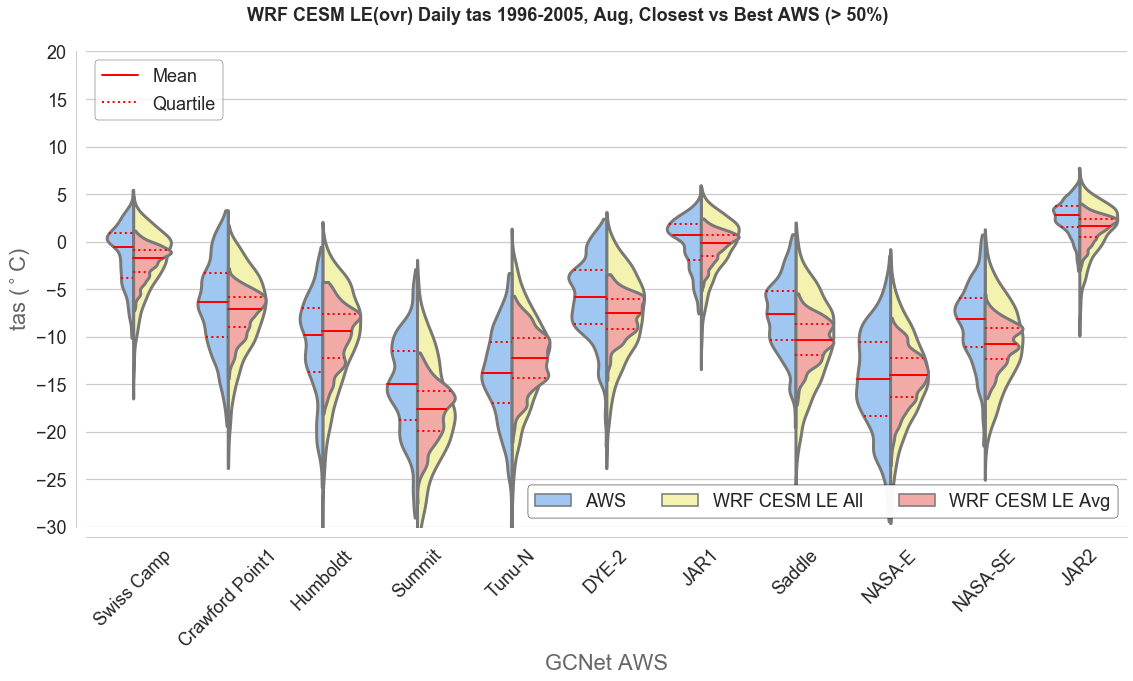

In [22]:
enss = "ovr"

yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Aug"
monSub = [8]
##scaleType = "area"  # no good due to doing plots twice
scaleType = "count" # subjectively best choice
# scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": "quartile" } )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( TawsValid, None, Tmodel3Valid, Tmodel1Valid, titleStr, "AWS", modelName, ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss, subStr, "eps" )

Compare WRF and original CESM data
====

Read/create CESM LE metadata
----

In [23]:
suff2 = str(Syr)+"0101-"+str(Eyr)+"1231"

# #  interpolated data
# modelFN = "cesmle_tas_interp_"+suff2+".nc"
# Mint = Model("cesmle_geog_sub.nc", modelFN)
# Mint.loadMeta()

# closest point data
modelFN = "../cesmle/cesmle_tas_closest_"+suff2+".nc"
Mcl2 = Model("../cesmle/cesmle_geog_sub.nc", modelFN)
Mcl2.loadMeta()

# geography
Mcl2.setDomain( (minLat, maxLat, minLon, maxLon) )

1d dataset


Load CESM LE data, ens avg
----

In [24]:
ens = -1
enss = "avg"

srcFile = "Closest"
timeModel = Mcl2.loadData( "time", True )
Tmodel11 = Mcl2.loadData( varName, True, ens )
Tmodel11.columns = awsCols

# add column with just the year (for subsetting later)
Tmodel11['year'] = Tmodel11["Time"].apply( lambda Tmodel11 : 
                                    datetime(year=Tmodel11.year, month=Tmodel11.month, day=Tmodel11.day).year)
# add column with just the month (for subsetting later)
Tmodel11['month'] = Tmodel11["Time"].apply( lambda Tmodel11 : 
                                    datetime(year=Tmodel11.year, month=Tmodel11.month, day=Tmodel11.day).month)

# drop column 1 (Time)
Tmodel11 = Tmodel11.iloc[:,1:]

Load CESM LE data, ALL
----

In [25]:
ens = -2
enss = "all"

srcFile = "Closest"
timeModel = Mcl2.loadData( "time", True )
Tmodel13 = Mcl2.loadData( varName, True, ens )
Tmodel13.columns = awsCols

# add column with just the year (for subsetting later)
Tmodel13['year'] = Tmodel13["Time"].apply( lambda Tmodel13 : 
                                    datetime(year=Tmodel13.year, month=Tmodel13.month, day=Tmodel13.day).year)
# add column with just the month (for subsetting later)
Tmodel13['month'] = Tmodel13["Time"].apply( lambda Tmodel13 : 
                                    datetime(year=Tmodel13.year, month=Tmodel13.month, day=Tmodel13.day).month)

# drop column 1 (Time)
Tmodel13 = Tmodel13.iloc[:,1:]

Closest, CESMLE period, JJA:  compare CESM & WRF, average to all
-----------

y-axis limits: -35, 15


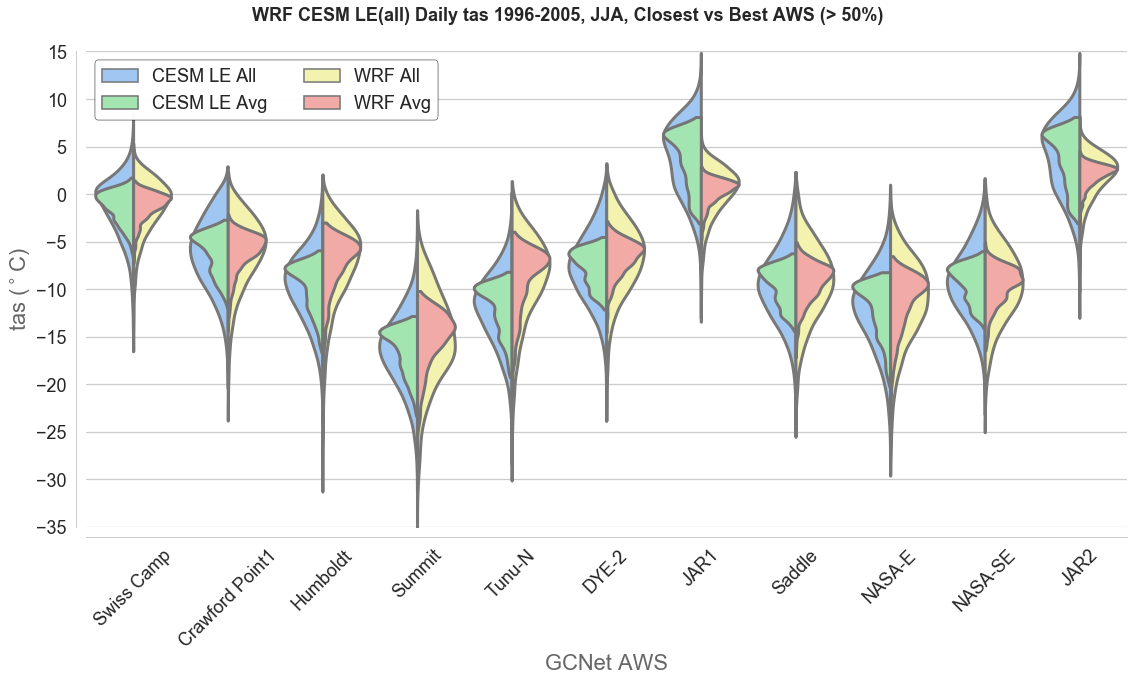

In [26]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "JJA"
monSub = [ 6, 7, 8 ]
##scaleType = "area"  # no good due to doing plots twice
# scaleType = "count" # subjectively best choice
scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": None, "legLoc": compLoc} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel11Valid, _ = subsetData( Tmodel11, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel13Valid, _ = subsetData( Tmodel13, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( Tmodel13Valid, Tmodel11Valid, Tmodel3Valid, Tmodel1Valid, titleStr, "CESM LE", "WRF", ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss+"-avg", subStr, "eps" )

Closest, CESMLE period, Jun:  compare CESM & WRF, average to all
-----------

y-axis limits: -30, 20


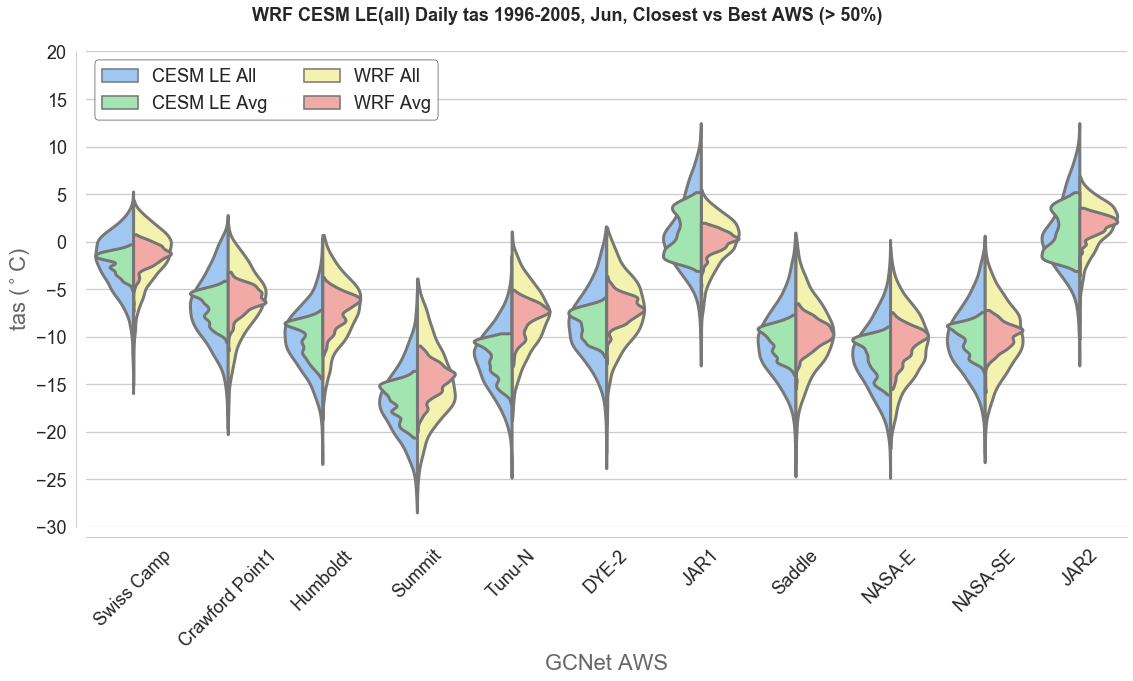

In [27]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jun"
monSub = [6]
##scaleType = "area"  # no good due to doing plots twice
# scaleType = "count" # subjectively best choice
scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": None, "legLoc": compLoc} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel11Valid, _ = subsetData( Tmodel11, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel13Valid, _ = subsetData( Tmodel13, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( Tmodel13Valid, Tmodel11Valid, Tmodel3Valid, Tmodel1Valid, titleStr, "CESM LE", "WRF", ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss+"-avg", subStr, "eps" )

Closest, CESMLE period, Jul:  compare CESM & WRF, average to all
-----------

y-axis limits: -30, 20


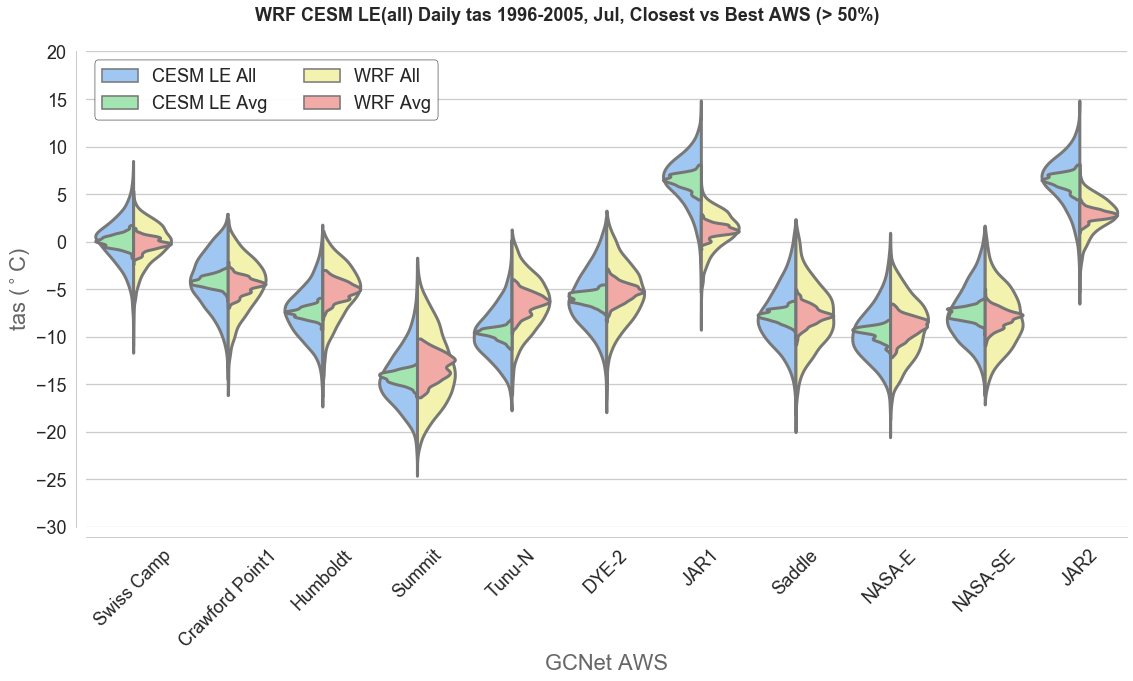

In [28]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Jul"
monSub = [7]
##scaleType = "area"  # no good due to doing plots twice
# scaleType = "count" # subjectively best choice
scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": None, "legLoc": compLoc} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel11Valid, _ = subsetData( Tmodel11, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel13Valid, _ = subsetData( Tmodel13, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( Tmodel13Valid, Tmodel11Valid, Tmodel3Valid, Tmodel1Valid, titleStr, "CESM LE", "WRF", ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss+"-avg", subStr, "eps" )

Closest, CESMLE period, Aug:  compare CESM & WRF, average to all
-----------

y-axis limits: -30, 20


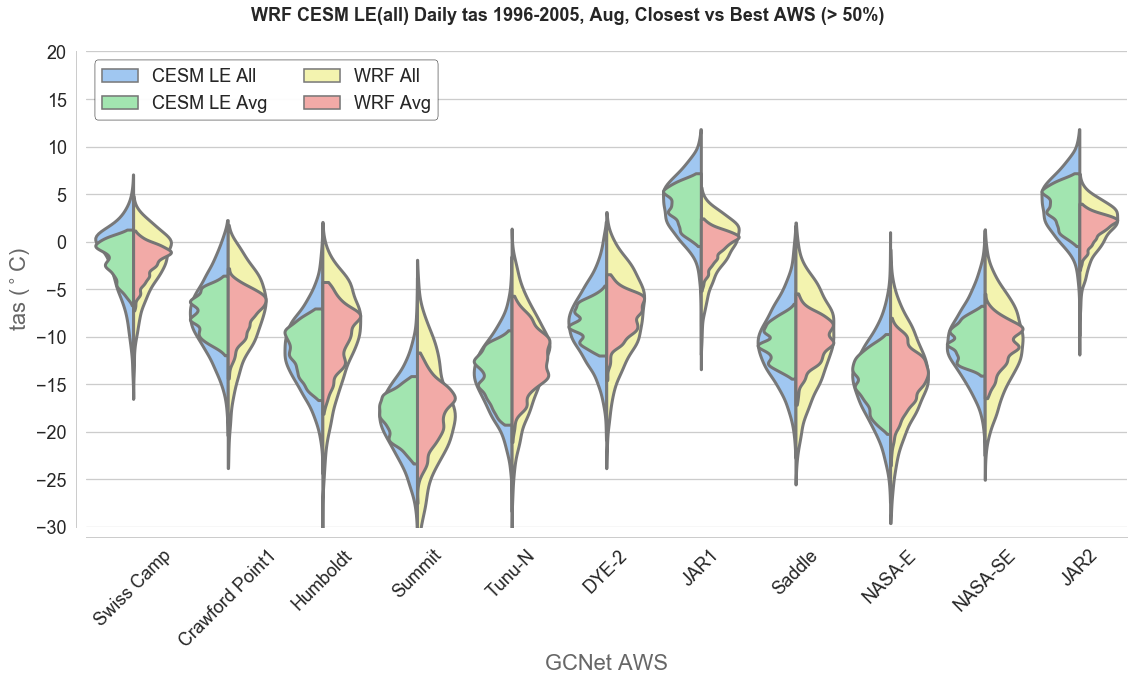

In [29]:
yrStartP = Syr
yrEndP = Eyr
yrRange = (yrStartP,yrEndP)
yrRangeAWS = (1996,2005)
qcCutoff = 50
subStr = "Aug"
monSub = [8]
##scaleType = "area"  # no good due to doing plots twice
# scaleType = "count" # subjectively best choice
scaleType = "width" # probably also ok
P.setOption( {"bandWidth": 0.2, "type": subStr, "scale": scaleType, "inner2": None, "legLoc": compLoc} )

TawsValid, qcIX = subsetData( Taws, yrRangeAWS, monSub, A.qcStats, qcCutoff )
Tmodel1Valid, _ = subsetData( Tmodel1, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel3Valid, _ = subsetData( Tmodel3, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel11Valid, _ = subsetData( Tmodel11, yrRange, monSub, A.qcStats, qcCutoff, qcIX )
Tmodel13Valid, _ = subsetData( Tmodel13, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, subStr, True )
P.makePlots2( Tmodel13Valid, Tmodel11Valid, Tmodel3Valid, Tmodel1Valid, titleStr, "CESM LE", "WRF", ( "All", "Avg" ) )
# plt.ylim(-25, 20);

P.saveFigure( modelName, varName, srcFile, yrRange, enss+"-avg", subStr, "eps" )

Load interpolated WRF(CESM LE) data
------
NOTE: have not done interpolated data for wrf(cesmle) yet and may NOT do it...

In [30]:
# srcFile = "Interpolated"
# timeModel = Mint.loadData( "time", True )
# Tmodel2 = Mint.loadData( varName, True, ens )
# Tmodel2.columns = awsCols

# # add column with just the year (for subsetting later)
# Tmodel2['year'] = Tmodel2["Time"].apply( lambda Tmodel2 : 
#                                     datetime(year=Tmodel2.year, month=Tmodel2.month, day=Tmodel2.day).year)
# Tmodel2['month'] = Tmodel2["Time"].apply( lambda Tmodel2 : 
#                                     datetime(year=Tmodel2.year, month=Tmodel2.month, day=Tmodel2.day).month)

# # drop column 1 (Time)
# Tmodel2 = Tmodel2.iloc[:,1:]

Interpolated, WRF(CESMLE) period, subset to Jul
-----------

In [31]:
# bandWidth=0.1
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# qcCutoff = 50

# TawsValid, qcIX = subsetData( Taws, yrRange, None, A.qcStats, qcCutoff )
# TmodelValid, _ = subsetData( Tmodel2, yrRange, None, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, srcFile, yrRange, enss, allStr, True )
# makePlots( TawsValid, TmodelValid, titleStr, "AWS", modelName )

# saveFigure( modelName, varName, srcFile, yrRange, enss, allStr, "eps" )

Closest vs Interpolated, CESMLE period
-----------

In [32]:
# bandWidth=0.1
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# qcCutoff = 50

# TawsValid, qcIX = subsetData( Taws, yrRange, None, A.qcStats, qcCutoff )
# Tmodel1Valid, _ = subsetData( Tmodel1,  yrRange, None, A.qcStats, qcCutoff, qcIX )
# Tmodel2Valid, _ = subsetData( Tmodel2, yrRange, None, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, None, yrRange, enss, allStr, True )
# makePlots( Tmodel1Valid, Tmodel2Valid, titleStr, "Closest", "Interpolated" )

# saveFigure( modelName, varName, None, yrRange, enss, allStr, "eps" )

Closest vs Interpolated, CESMLE period, JJA
-----------

In [33]:
# bandWidth=0.2
# yrStartP = Syr
# yrEndP = Eyr
# yrRange = (yrStartP,yrEndP)
# qcCutoff = 50
# subStr = "JJA"
# monSub = [6,7,8]

# TawsValid, qcIX = subsetData( Taws, yrRange, monSub, A.qcStats, qcCutoff )
# Tmodel1Valid, _ = subsetData( Tmodel1,  yrRange, monSub, A.qcStats, qcCutoff, qcIX )
# Tmodel2Valid, _ = subsetData( Tmodel2, yrRange, monSub, A.qcStats, qcCutoff, qcIX )

# titleStr = makeTitle( modelName, varName, None, yrRange, enss, subStr, True )
# makePlots( Tmodel1Valid, Tmodel2Valid, titleStr, "Closest", "Interpolated" )

# saveFigure( modelName, varName, None, yrRange, enss, subStr, "eps" )